In [2]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install fastai==2.6.3 --no-deps
!pip install self_supervised

In [3]:
import fastai
import self_supervised
import torch
fastai.__version__ #Check that version is 2.6.3

'2.6.3'

In [4]:
#This is not needed unless running SBT
#!pip uninstall --yes git+https://github.com/hamish-haggerty/SVGD_packages.git#egg='Base_Stein'
!pip install git+https://github.com/hamish-haggerty/SVGD_packages.git#egg='Base_Stein'

  Cloning https://github.com/hamish-haggerty/SVGD_packages.git to /tmp/pip-install-m40ncx_5/base-stein_a71dd6adb70a49c7bcea2205737b06a4
  Running command git clone --filter=blob:none --quiet https://github.com/hamish-haggerty/SVGD_packages.git /tmp/pip-install-m40ncx_5/base-stein_a71dd6adb70a49c7bcea2205737b06a4
  Resolved https://github.com/hamish-haggerty/SVGD_packages.git to commit bbaeeb9c07b01a45a3a87c5843b183a6cc884ab4
  Preparing metadata (setup.py) ... done
  Created wheel for Base_Stein: filename=Base_Stein-0.0.0-py3-none-any.whl size=4089 sha256=a4d5fb720a5011d64ab166db9dcc6b634f4ac060cd0515cc0b43a626b17f509e
  Stored in directory: /tmp/pip-ephem-wheel-cache-w2hm_wdp/wheels/f3/4b/c4/586c145d9208aecc7b612cf639a19d1e998ebdfd4297955fce
Successfully built Base_Stein


In [6]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import inspect
import warnings
import random
warnings.filterwarnings("ignore")
from Base_Stein.SVGD_classes import *

In [7]:
#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): return self.projector(self.encoder(x))

In [8]:
#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

#Similar to above. Simple API to make the BT model:

In [9]:
#BarlowTwins Callback
#The following parameters can be passed:
# - aug_pipelines
# Imb lambda is the weight for redundancy reduction term in the loss function

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

In [10]:
#A random degree 2 polynomial, of the form a*x^2 + b*x, where a and b are in {-1,1}, {-1,0,1} respectively
def random_poly(A):
    coeff1 = random.choice([-1,0,1])
    coeff2 = random.choice([-1,1]) #degree 2 term
    B = coeff1*A + coeff2*A.pow(2) 
    return B
    

In [11]:
#Uniform random number between a and b
def Unif(a,b):
    return (b-a)*torch.rand(1).item()+a

In [13]:
#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        
        #Uncomment to run standard BT
    
#     def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
#         bs,nf = pred.size(0)//2,pred.size(1)

#         z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

#         z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
#         z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
#         C = (z1norm.T @ z2norm) / bs 
#         cdiff = (C - self.I)**2
#         loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
#         return loss

    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        #All standard, from BT
        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2
        
        #polyprob=0.1
        polyprob=0.25
        temrand = random.random()
        if temrand < polyprob: #With some probability we want off diag terms to be (quadratic) say.

            #This block is "best so far"
            z1norm_2 = random_poly(z1norm)       
            z2norm_2 = z2norm

            C_2 = (z1norm_2.T @ z2norm_2) / bs
            
            cdiff_2 = (C_2)**2 #don't need to subtract I as only looking at off diag terms
            
        else:
            cdiff_2 = cdiff
            
        l2 = cdiff_2*(1-self.I)*self.lmb #Is either the standard term - or not.

        loss = (cdiff*self.I + l2).sum() 
        return loss

    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [19]:
#Debugging cell - delete later (similar to cell below)
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=125,projection_size=125)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=True)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn.fit(1) #300

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


epoch,train_loss,valid_loss,time
0,39.456692,37.395454,00:06


In [15]:
#Get the dataloader and set batch size
bs=512
path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
items=items.shuffle()

items1 = items[0:2000]

split = RandomSplitter(valid_pct=0.5) #randomly split training set into training and validation
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items1, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items1)) #Or do we want this?
dls = tds.dataloaders(bs=bs, after_item=[ToTensor(), IntToFloatTensor()], device='cuda')

#Evaluate linear classifier on this guy
items2 = items[2000:]
split = RandomSplitter(valid_pct=0.99) #randomly split training set into training and validation
tds_new = Datasets(items2, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items2)) #Or do we want this?
dls_new = tds_new.dataloaders(bs=bs, after_item=[ToTensor(), IntToFloatTensor()], device='cuda')


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


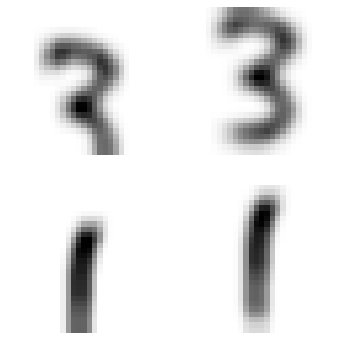

In [17]:
#A "reasonable" composite augmentation: initially copy pasted BT. We run this cell a few times to check it makes sense
#Also define encoder and model
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=True)
#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])

#dls.valid.bs = len(dls.valid_ds) #Set the validation dataloader batch size to be the length of the validation dataset

b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=2)

In [18]:
#Simple linear classifier
class LinearClassifier(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,10) #As 10 classes for mnist
        
    def forward(self,x):
        x = cast(self.fc1(x),Tensor) #so we have to use cross entropy loss. cast is because using old version fastai 
        return x

In [ ]:
#Train Classifier on encoder(mnist) for (at the moment) one epoch

fastai_encoder.eval()

zdim=1024 #see above
head = LinearClassifier(zdim=zdim)
device='cuda'
head.to(device)
optimizer = torch.optim.Adam(head.parameters())
criterion = nn.CrossEntropyLoss()
#EPOCHS=100

for epoch in range(10):
    for x,y in dls.train:
        #break 

        #b = dls.train.one_batch() #Seems need dls[0] or dls.train for training ... dls[1] is validation see here https://docs.fast.ai/data.core.html#DataLoaders.__getitem__
        #x,y = b[0],b[1]

        loss = criterion(head(fastai_encoder(x)),y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print(loss)
print('done')
        

In [ ]:
#Test result of above cell on the validation set - assumes that batch size of valid-dataloader is = number of valid samples                                        

# print('The validation batch size is: {} '.format(dls.valid.bs))
# input()


#b = dls.valid.one_batch()

fastai_encoder.eval()

num_correct=0
for x,y in dls_new.valid:
    ypred = head(fastai_encoder(x))
    correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
    num_correct += correct.sum()

print(num_correct/len(dls_new.valid_ds))
    

In [ ]:
#Some PRELIMINARY results...
#300 epochs, train/val = 1000/1000, batch_size=512 hidden_size=proj_size=125, train linear classifier 10 epochs. Also, evaluate on ~58k remaining
#Need to beat ~ 0.6 which is just training linear classifier
Supervised = 0.6
BT = 0.7327
quadratic_polyprob25 = 0.7865
random_poly_polyprob25 = 0.7985 #Still best

Preliminary results for MNIST:

We perform some ablations on the Barlow twins loss function: Instead of the $\operatorname{Corr}(z_{1i},z_{2j})=0$ constraints, we 
have a constraint $\operatorname{Corr}(z_{1i},p(z_{2j}))=0$, where $p$ is a random polynomial (sampled for each batch). Motivation: The $\operatorname{Corr}(z_{1i},z_{2j})$ constraint in BT is a redundancy reduction term. Really want these terms to be statistically independent, not just uncorrelated. It is a theorem that if $\operatorname{Corr}(h(X),h(Y))=0$ for all $h$ in a suitable class of functions (e.g. continuous functions) THEN $X$ and $Y$ are independent. 

Baseline: Train BT on 1000 (unlabelled) MNIST samples (around 1.67% of the available training data), to learn a representation (125 dimensional). Then take the frozen representation, and on the same samples train a linear classifier head (with the labels). Evaluate on ~58k MNIST samples. Result: 73.27% accuracy

Modification: We take p to be a low dimensional polynomial. Then training modified BT, (MBT) on the same 1k MNIST samples as above, and evaluating on the remaining ~58k, we get 79.85% accuracy, which is larger than 73.27% for Barlow twins. As a point of comparison, if we train a linear classifier on the raw 28x28 pixels (instead of the frozen representation), accuracy is 60%, so as expected training a linear classifier on a learned representation is superior to training on the raw pixels.

Concerns: Usually these is a mistake, especially when results are positive... Need to test everything carefully. Have been experimenting on MNIST for a while, so need to test on a different dataset, maybe CIFAR or miniImagenet. 

**Plan for next week or so**

* Test above results more carefully by running several times (on different 1k samples each time), and try performing ablations similar to the BT paper. I think it is likely I have made several mistakes, as is typical..
* Importantly: test the above loss function ablations on another dataset to MNIST. 
* Spend ~ 50% of time continuing to read literature. Especially want to read VICReg paper, which builds on BT paper
* Need to improve Latex skills, and in particular learn how to create good graphics / visuals




In [ ]:
# #Just train a linear classifier (no encoder)
# #Basically cell above but remove encoder and some re-shaping
# zdim=28*28 #see above
# head = LinearClassifier(zdim=zdim)
# head.to(device)
# optimizer = torch.optim.Adam(head.parameters())
# criterion = nn.CrossEntropyLoss()


# for x,y in dls.train:
#     #break
#     #b = dls.train.one_batch() #see here https://docs.fast.ai/data.core.html#DataLoaders.__getitem__
#     #x,y = b[0],b[1]

#     x=x.view(bs,zdim)
#     x=cast(x, Tensor) #Have to do this when using old version of fastai for some reason...
    
#     out = head(x)
#     loss = criterion(out,y)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()


In [ ]:
# #Test result of above cell, (i.e. just a linear classifier), on the validation set - assumes that batch size of valid-dataloader is = number of valid samples                                        
# num_correct=0
# for x,y in dls_new.valid:

#     x=x.view(x.shape[0],zdim)
#     x=cast(x, Tensor) #Have to do this when using old version of fastai for some reason...
    
#     ypred = head(x)
#     correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
#     num_correct += correct.sum()
    
# print(num_correct/len(dls_new.valid_ds))